## Imports and constants

In [21]:
import math
import os
import shutil
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from functools import partial, reduce

In [40]:
ROOTDIR = "C:/Users/christopher/Documents/autosim"
SPOT = "3b_CO_BTN_mk2"
DATADIR = f"{ROOTDIR}/out/sims/{SPOT}"

In [41]:
POTSIZE = 185

ORDER = ["2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K", "A"]
RANK = {card: i for i, card in enumerate(ORDER)}

SUIT_ORDER = ["d", "h", "s", "c"]
SUIT_RANK = {s: i for i, s in enumerate(SUIT_ORDER)}

SUIT_SYMBOLS = {
    "d": "\u2662",
    "h": "\u2661",
    "s": "\u2660",
    "c": "\u2663",
}

## Helper methods

In [42]:
def rank(board, method="sort"):
    """
    Assign a rank score for a board.
    
    If method == "sort", only the rank of the highest card
    matters, unless its a tie, in which case the other cards are considered.

    If method == "sum", return the sum of the ranks of the individual cards.

    """
    assert method in ["sort", "sum"]
    cards = board[0], board[2], board[4]
    ranks = [RANK[card] for card in cards]
    sorted_ranks = sorted(ranks)
    if method == "sum":
        return sum(sorted_ranks)
    else:
        return sum([13 ** i * r for i, r in enumerate(sorted_ranks)])

In [43]:
def strategy_as_perc(s):
    if not s.isnumeric():
        return s
    perc = int((int(s) / POTSIZE) * 100)
    return f"b{perc}"

In [44]:
def reorder_board(b):
    """
    Sort the cards for a board such that the highest rank cards come first, and
    the suits are in the order (clubs, spades, hearts, diamonds).
    """
    cards = [b[:2], b[2:4], b[4:6]]
    sorted_cards = sorted(cards, key=lambda c: (RANK[c[0]], SUIT_RANK[c[1]]), reverse=True)
    return "".join(sorted_cards)

In [45]:
def get_suitedness(board):
    suits = [board[1], board[3], board[5]]
    counts = list(Counter(suits).values())
    if max(counts) == 1:
        return "rainbow"
    elif max(counts) == 2:
        return "twotone"
    elif max(counts) == 3:
        return "monotone"
    else:
        raise ValueError(f"Invalid board: {board}")

In [46]:
def pretty_board(board):
    suits = [board[1], board[3], board[5]]
    pretty_suits = [SUIT_SYMBOLS[s] for s in suits]
    new_board = list(board)
    new_board[1] = pretty_suits[0]
    new_board[3] = pretty_suits[1]
    new_board[5] = pretty_suits[2]
    return "".join(new_board)

In [47]:
def get_ybounds(evs, full_ev, alpha=0.2):
    min_ev = min(evs)
    max_ev = max(max(evs), full_ev)
    gap = max_ev - min_ev
    ylow = min_ev - alpha * gap
    yhigh = max_ev + alpha * gap / 2
    return ylow, yhigh


def plot_strategies(data, board, spot):
    full_ev = full_strat_evs[board]
    board_data = data[data["board"] == board]
    ylow, yhigh = get_ybounds(board_data["ev"], full_ev)
    sns.barplot(x="strategy", y="ev", data=board_data)
    plt.axhline(y=full_ev, linestyle="--")
    plt.title(pretty_board(board))
    plt.xlabel("")
    plt.ylim([ylow, yhigh])

## Data prep

In [48]:
dfs = []
for board in os.listdir(DATADIR):
    datapath = f"{DATADIR}/{board}/data.csv"
    df = pd.read_csv(datapath)
    df["board"] = board
    cols = df.columns.tolist()
    newcols = cols[-1:] + cols[:-1]
    df = df[newcols]
    dfs.append(df)
data = pd.concat(dfs)
data = data.reset_index(drop=True)

In [49]:
data["strategy"] = data["strategy"].apply(strategy_as_perc)

data["board"] = data["board"].apply(reorder_board)

data["suitedness"] = data["board"].apply(get_suitedness)

data["rank"] = data["board"].apply(lambda b: rank(b))

In [53]:
full_strat_data = data[data["strategy"] == "full"][["board", "ev"]]
full_strat_evs = {board: ev for board, ev in full_strat_data.values.tolist()}
strat_evs_sorted = sorted(full_strat_evs.items(), key=lambda i: i[1], reverse=True)
for board, ev in strat_evs_sorted:
    print(f"{pretty_board(board)}: {ev:.2f}")

K♣T♢2♠: 141.83
K♠6♠6♢: 138.68
A♠J♢3♠: 133.04
A♠4♠4♢: 132.26
A♠J♢6♠: 131.64
Q♠T♠2♢: 128.59
K♢6♠4♠: 126.13
Q♠7♠7♢: 124.95
J♣8♢2♠: 122.58
A♢T♠9♠: 122.50
Q♣9♢3♠: 119.29
K♣8♢7♠: 118.56
J♣9♢5♠: 117.81
K♠8♠5♠: 116.30
J♢T♠7♠: 112.36
A♢5♠4♠: 111.35
T♣7♢3♠: 111.23
9♣4♢2♠: 109.52
Q♠8♢6♠: 106.43
Q♢9♠7♠: 106.14
T♢6♠3♠: 106.14
5♠5♢4♠: 105.10
8♣5♢3♠: 101.61
6♠5♠2♠: 98.44


In [54]:
data = data[data["strategy"] != "full"]

data["ev_upper"] = data.apply(lambda row: full_strat_evs[row.board], axis=1)

data["ev_diff"] = data["ev"] - data["ev_upper"]

In [55]:
data

,board,strategy,ev,exploitability,path,suitedness,rank,ev_upper,ev_diff
1,QsTs2d,b20,128.432,0.731,C:/Users/christopher/Documents/autosim/out/3b_...,twotone,1794,128.594,-0.162
2,QsTs2d,b30,128.577,0.780,C:/Users/christopher/Documents/autosim/out/3b_...,twotone,1794,128.594,-0.017
3,QsTs2d,b49,127.895,0.798,C:/Users/christopher/Documents/autosim/out/3b_...,twotone,1794,128.594,-0.699
4,QsTs2d,b75,126.414,0.874,C:/Users/christopher/Documents/autosim/out/3b_...,twotone,1794,128.594,-2.180
6,9c4d2s,b20,104.590,0.839,C:/Users/christopher/Documents/autosim/out/3b_...,rainbow,1209,109.515,-4.925
...,...,...,...,...,...,...,...,...,...
114,JdTs7s,b75,110.940,0.660,C:/Users/christopher/Documents/autosim/out/3b_...,twotone,1630,112.358,-1.418
116,AdTs9s,b20,122.578,0.768,C:/Users/christopher/Documents/autosim/out/3b_...,twotone,2139,122.502,0.076
117,AdTs9s,b30,122.355,0.741,C:/Users/christopher/Documents/autosim/out/3b_...,twotone,2139,122.502,-0.147
118,AdTs9s,b49,121.635,0.866,C:/Users/christopher/Documents/autosim/out/3b_...,twotone,2139,122.502,-0.867


In [62]:
list(data["path"])[0]

'C:/Users/christopher/Documents/autosim/out/3b_CO_BTN_mk2/2dTsQs/flop37.cfr'

In [56]:
for path in list(data["path"]):
    assert os.path.isfile(path), f"{path} is not a path."

## Sort best simplifications into separate folder

In [57]:
SIMPL_DIR = f"{ROOTDIR}/simplifications/{SPOT}"
os.makedirs(SIMPL_DIR, exist_ok=True)

max_idxs = data.groupby("board")["ev"].transform(max) == data["ev"]
for _, row in data[max_idxs].iterrows():
    newpath = f"{SIMPL_DIR}/{row.board}_{row.strategy}.cfr"
    shutil.copyfile(src=row.path, dst=newpath)

## EV visualizations

In [58]:
boards = data["board"].unique().tolist()
print(f"Number of boards: {len(boards)}")

Number of boards: 24


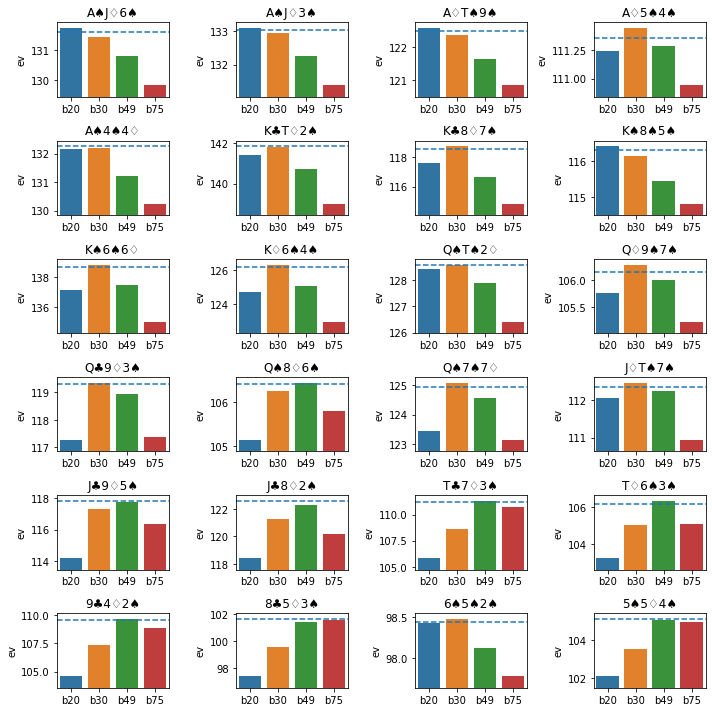

In [63]:
sorted_boards = sorted(boards, key=rank, reverse=True)

ncols = int(math.sqrt(len(boards)))
nrows = math.ceil(len(boards) / ncols)

plt.figure(figsize=(10, 10))
for i, board in enumerate(sorted_boards):
    plt.subplot(nrows, ncols, i + 1)
    plot_strategies(data, board, SPOT)
plt.tight_layout()
plt.savefig(f"../out/figures/{SPOT}")
plt.show()

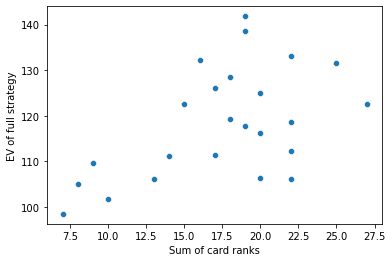

In [64]:
tmp = data
tmp["rank_sum"] = tmp["board"].apply(partial(rank, method="sum"))
tmp = tmp[tmp["strategy"] == "b20"]

plt.figure()
sns.scatterplot(x="rank_sum", y="ev_upper", data=tmp)
plt.xlabel("Sum of card ranks")
plt.ylabel("EV of full strategy")
plt.show()